In [ ]:
# %% [markdown]
# # Dihedral Group Dataset (NumPy + Matplotlib only)
#
# Builds the left-regular representation of D_n, encodes elements by P_g x with a
# mean-centered base vector x in R^{|G|}, constructs the dataset
# ((g·x, h·x) -> (gh)·x), and visualizes permutation matrices and a 2D PCA
# (implemented via NumPy SVD).
#
# Ordering convention:
#   [r^0, r^1, ..., r^{n-1}, r^0 s, r^1 s, ..., r^{n-1} s]
# For n=3, printed labels: ["e","r","r^2","s","sr","sr^2"].

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# ========== Core group machinery ==========

Element = tuple  # ('rot' or 'ref', k)

def elements_Dn(n: int):
    """Elements in fixed order: rotations then reflections with s on the right."""
    return [('rot', k) for k in range(n)] + [('ref', k) for k in range(n)]

def multiply_Dn(a: Element, b: Element, n: int) -> Element:
    """Group multiplication in D_n with normal form r^k and r^k s (s on the right)."""
    ka, ia = a; kb, ib = b
    ia %= n; ib %= n
    if ka == 'rot' and kb == 'rot':    # (r^ia)(r^ib) = r^{ia+ib}
        return ('rot', (ia + ib) % n)
    if ka == 'rot' and kb == 'ref':    # (r^ia)(r^ib s) = r^{ia+ib} s
        return ('ref', (ia + ib) % n)
    if ka == 'ref' and kb == 'rot':    # (r^ia s)(r^ib) = r^{ia-ib} s
        return ('ref', (ia - ib) % n)
    # (r^ia s)(r^ib s) = r^{ia - ib}
    return ('rot', (ia - ib) % n)

def left_perm_matrix(g: Element, order, n: int) -> np.ndarray:
    """Permutation matrix P_g s.t. P_g e_h = e_{g·h} under 'order'."""
    m = len(order)
    idx = {order[i]: i for i in range(m)}
    M = np.zeros((m, m), dtype=int)
    for j, h in enumerate(order):
        gh = multiply_Dn(g, h, n)
        i = idx[gh]
        M[i, j] = 1
    return M

def label_Dn(el: Element, n: int) -> str:
    """Human-readable label matching the paper's D3 example."""
    kind, k = el
    k %= n
    if kind == 'rot':
        if k == 0: return 'e'
        if k == 1: return 'r'
        return f'r^{k}'
    # reflections: r^k s, printed as s, sr, sr^2, ...
    if k == 0: return 's'
    if k == 1: return 'sr'
    return f'sr^{k}'
    
def parse_el(s: str, n: int):
    """
    Parse element strings under the ORIGINAL convention:
      ('rot', k)  == r^k
      ('ref', k)  == r^k s   (we *print* these as "s", "sr", "sr^k")
    Examples: "e", "r", "r5", "r^7", "s", "sr", "sr7", "sr^20", "r^-3", "sr^-2"
    """
    t = s.strip().lower().replace(" ", "")
    def parse_exp(exp: str) -> int:
        if exp == "" or exp == "^":
            return 1
        if exp.startswith("^"):
            exp = exp[1:]
        return int(exp) % n

    if t in ("e", "r0", "r^0"):
        return ('rot', 0)
    if t == "s":
        return ('ref', 0)
    if t.startswith("sr"):
        k = parse_exp(t[2:])
        return ('ref', k)
    if t.startswith("r"):
        k = parse_exp(t[1:])
        return ('rot', k)
    raise ValueError(f"Unrecognized element string: {s!r}")

In [3]:
# ========== Encodings & dataset ==========

def mean_center_unit(x: np.ndarray) -> np.ndarray:
    x = x - np.mean(x)
    nrm = np.linalg.norm(x)
    return x / (nrm + 1e-12)

def build_encodings(n: int, seed: int = 0):
    """
    Returns:
      order: list[Element]
      labels: list[str]
      P: dict(Element -> permutation matrix)
      x: base vector in R^{|G|}
      enc: dict(Element -> P_g x)
    """
    rng = np.random.default_rng(seed)
    order = elements_Dn(n)
    labels = [label_Dn(g, n) for g in order]
    P = {g: left_perm_matrix(g, order, n) for g in order}

    x = rng.normal(size=len(order))
    x = mean_center_unit(x)

    enc = {g: P[g] @ x for g in order}
    return order, labels, P, x, enc

def build_dataset(n: int = 3, seed: int = 0):
    """
    Constructs arrays:
      X1, X2, Y ∈ R^{|G|^2 × |G|}
    where each row is (g·x, h·x) -> (gh)·x.
    """
    order, labels, P, x, enc = build_encodings(n=n, seed=seed)
    m = len(order)
    N = m * m
    X1 = np.zeros((N, m))
    X2 = np.zeros((N, m))
    Y  = np.zeros((N, m))
    pairs = []

    idx = 0
    for g in order:
        gx = enc[g]
        for h in order:
            hx  = enc[h]
            gh  = multiply_Dn(g, h, n)
            ghx = enc[gh]
            X1[idx] = gx
            X2[idx] = hx
            Y[idx]  = ghx
            pairs.append((g, h, gh))
            idx += 1

    return X1, X2, Y, pairs, order, labels, P, x, enc

In [4]:
# ========== Utilities: Cayley table (text), PCA via SVD, visuals ==========

def print_cayley_table(order, n: int):
    """Pretty-print Cayley table using only print()."""
    labels = [label_Dn(g, n) for g in order]
    w = max(len(s) for s in labels + ['·']) + 1

    def cell(s): return s.ljust(w)
    header = cell('·') + ''.join(cell(s) for s in labels)
    print(header)
    print('-' * len(header))
    for g in order:
        row = [label_Dn(multiply_Dn(g, h, n), n) for h in order]
        print(cell(label_Dn(g, n)) + ''.join(cell(s) for s in row))

def imshow_perm(M: np.ndarray, title: str):
    plt.figure()
    plt.imshow(M, interpolation='nearest')
    plt.title(title)
    plt.xlabel("column j")
    plt.ylabel("row i")
    plt.tight_layout()

Cayley table for D_3 (order = 6):

·    e    r    r^2  s    sr   sr^2 
-----------------------------------
e    e    r    r^2  s    sr   sr^2 
r    r    r^2  e    sr   sr^2 s    
r^2  r^2  e    r    sr^2 s    sr   
s    s    sr^2 sr   e    r^2  r    
sr   sr   s    sr^2 r    e    r^2  
sr^2 sr^2 sr   s    r^2  r    e    


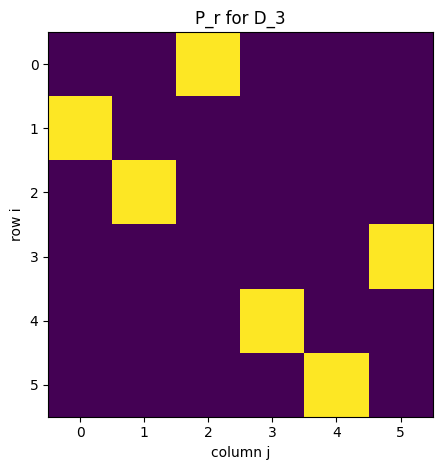

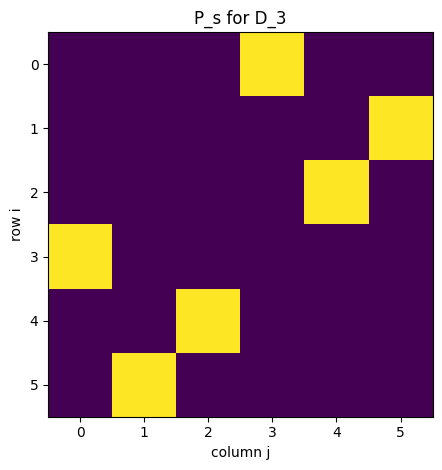

In [5]:
# ========== Example: D3 (change n below as needed) ==========

# Set n here (n >= 3)
n = 3
seed = 42

# Build everything (no plotting happens until you run the visualize cells)
X1, X2, Y, pairs, order, labels, P, x, enc = build_dataset(n=n, seed=seed)

# %% [markdown]
# ## Verify generators & Cayley table

# %%
# Print Cayley table to stdout
print("Cayley table for D_{} (order = {}):\n".format(n, 2*n))
print_cayley_table(order, n)

# Show permutation matrices for r and s
Pr = P[('rot', 1)]
Ps = P[('ref', 0)]
imshow_perm(Pr, f"P_r for D_{n}")
imshow_perm(Ps, f"P_s for D_{n}")

In [6]:
# ----- Build D_n × D_n utilities (no big matrices; we use index permutations) -----

def product_elements(order_G):
    """Lexicographic list of elements of G×G given a fixed order of G."""
    return [(a, b) for a in order_G for b in order_G]

def product_multiply(gpair, hpair, n):
    """(g1,g2)*(h1,h2) = (g1*h1, g2*h2) under D_n multiplication."""
    g1, g2 = gpair
    h1, h2 = hpair
    return (multiply_Dn(g1, h1, n), multiply_Dn(g2, h2, n))

def product_labels(gpair, n):
    """String label for a pair (g1,g2)."""
    g1, g2 = gpair
    return f"({label_Dn(g1, n)}, {label_Dn(g2, n)})"

def left_action_perm_indices(gpair, order_prod, n, idx_prod):
    """
    For element gpair ∈ G×G, return array I_of_J of length |G×G|,
    where for each basis index j (column), the result index i (row) satisfies:
      (P_{gpair}) e_j = e_i  with i = I_of_J[j].
    This lets us apply the permutation as: y[I_of_J] = x.
    """
    m = len(order_prod)
    I_of_J = np.empty(m, dtype=int)
    for j, hpair in enumerate(order_prod):
        prod = product_multiply(gpair, hpair, n)
        i = idx_prod[prod]
        I_of_J[j] = i
    return I_of_J

Random MNIST sample index 29636, label = 3


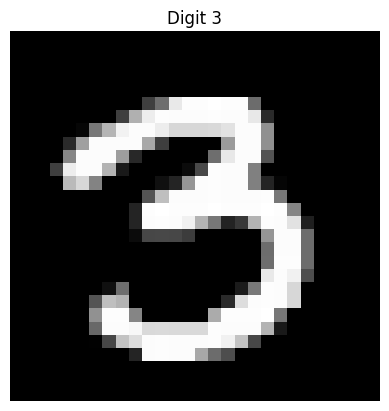

In [27]:
# Download (first run) and load MNIST training set
mnist_train = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Pick a random sample
idx = torch.randint(len(mnist_train), (1,)).item()
img, label = mnist_train[idx]   # img is shape (1,28,28), values in [0,1]

print(f"Random MNIST sample index {idx}, label = {label}")

# Display
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"Digit {label}")
plt.axis("off")
plt.savefig('x.pdf')
plt.show()

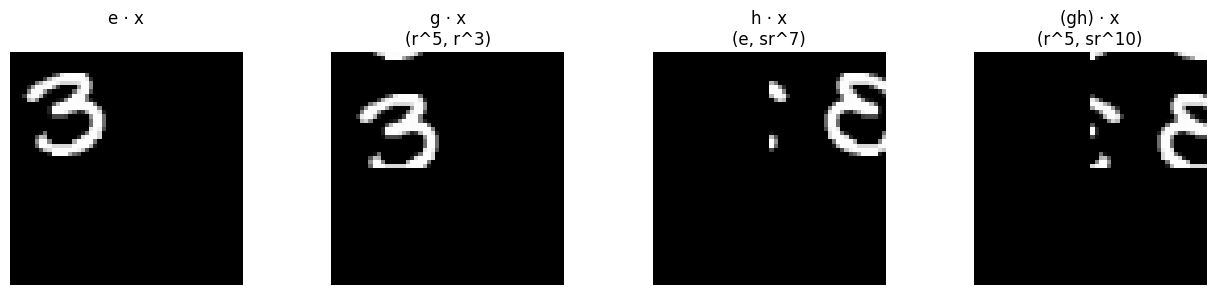

In [36]:
# ----- Set up D14 × D14 and indexing -----

n = 28
order_G  = elements_Dn(n)                         # D28 elements (56 of them)
order_GxG = product_elements(order_G)             # 56*56 = 4 * 784 elements
idx_GxG = {gpair: i for i, gpair in enumerate(order_GxG)}

# sanity: the action space matches a 28x28 image flattened
assert len(order_GxG) == 2*n * 2*n, "Expected 4 * 784 = 56×56 states for D28×D28."

# Construct image with top left corner is MNIST image
x_img = np.zeros((2*n, 2*n))
x_img[:28, :28] = img.numpy()

# Flatten to a NumPy vector of length 4 * 784
x_vec = x_img.reshape(-1)

# Optionally mean-center (uncomment if desired)
x_vec = x_vec - x_vec.mean()

# Choose a g, h from D28×D28
g_strings = ("r5", "r3")   # g = (g1, g2)
h_strings = ("e", "sr7")    # h = (h1, h2)
gpair = tuple(parse_el(s, n) for s in g_strings)
hpair = tuple(parse_el(s, n) for s in h_strings)
ghpair = product_multiply(gpair, hpair, n)

# Build permutation index maps for g and h (and compose for gh)
I_g  = left_action_perm_indices(gpair, order_GxG, n, idx_GxG)   # y[I_g] = x
I_h  = left_action_perm_indices(hpair, order_GxG, n, idx_GxG)
I_gh = left_action_perm_indices(ghpair, order_GxG, n, idx_GxG)

# Apply permutations to x (forward map j -> i, so: y[i_of_j] = x[j])
gx_vec  = np.empty_like(x_vec);  gx_vec[I_g]  = x_vec
hx_vec  = np.empty_like(x_vec);  hx_vec[I_h]  = x_vec
ghx_vec = np.empty_like(x_vec);  ghx_vec[I_gh] = x_vec

# Reshape back to 56×56 images for viewing
x_img = x_vec.reshape(2*n, 2*n)
gx_img  = gx_vec.reshape(2*n, 2*n)
hx_img  = hx_vec.reshape(2*n, 2*n)
ghx_img = ghx_vec.reshape(2*n, 2*n)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(13, 3))
axs[0].imshow(x_img, cmap="gray")
axs[0].set_title(f"e · x\n")
axs[1].imshow(gx_img, cmap="gray")
axs[1].set_title(f"g · x\n{product_labels(gpair, n)}")
axs[2].imshow(hx_img, cmap="gray")
axs[2].set_title(f"h · x\n{product_labels(hpair, n)}")
axs[3].imshow(ghx_img, cmap="gray")
axs[3].set_title(f"(gh) · x\n{product_labels(ghpair, n)}")
for ax in axs: 
    ax.axis("off")
plt.tight_layout()
plt.show()

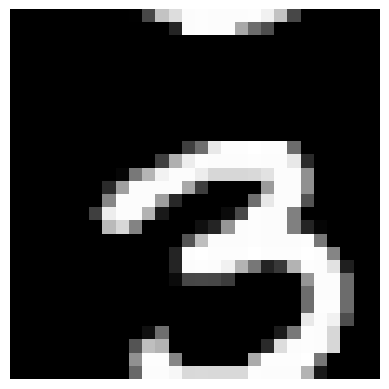

In [38]:
plt.axis("off")
plt.imshow(gx_img[:28,:28], cmap="gray")
plt.savefig('x.pdf')

Number of elements: 8: [(+, 0[2pi/4]), (+, 1[2pi/4]), (+, 2[2pi/4]), (+, 3[2pi/4]), (-, 0[2pi/4]), (-, 1[2pi/4]), (-, 2[2pi/4]), (-, 3[2pi/4])]


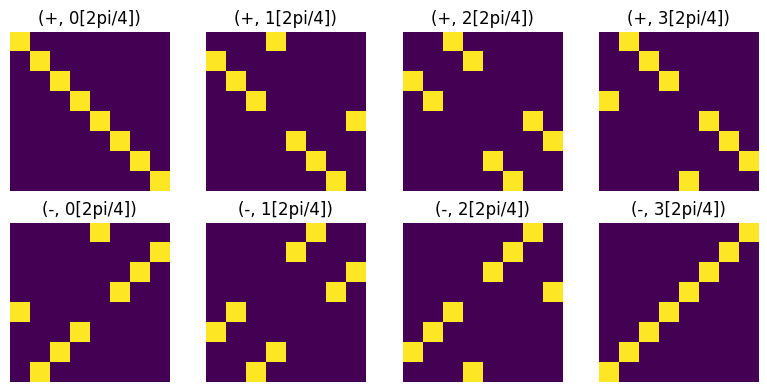

In [ ]:
# conda install gfortran
# pip install --prefer-binary pyshtools
# pip install py3nj==0.2.1
# pip install escnn
import matplotlib.pyplot as plt
import numpy as np
from escnn.group import *

group = DihedralGroup(N=4)

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
axs = axs.flatten()
for i, g in enumerate(group.elements):
    matrix = group.representations["regular"](g)
    axs[i].imshow(matrix)
    axs[i].set_title(f"{g}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [6]:
group.representations["regular"]

D4|[regular]:8

In [8]:
for g in group.elements:
    print(g)
    #print(group.representations["regular"](g))
    print(group.representations["regular"](g).shape)

(+, 0[2pi/4])
(8, 8)
(+, 1[2pi/4])
(8, 8)
(+, 2[2pi/4])
(8, 8)
(+, 3[2pi/4])
(8, 8)
(-, 0[2pi/4])
(8, 8)
(-, 1[2pi/4])
(8, 8)
(-, 2[2pi/4])
(8, 8)
(-, 3[2pi/4])
(8, 8)
